In [ ]:
# Consensus Peak Calling Notebook

This notebook generates consensus peaks across cell types for a species using the `atac_pipeline` module.

## Workflow
1. **Load narrowPeak files** - Filter by q-value and minimum peaks
2. **Harmonize chromosome names** - Ensure consistent naming (chr prefix)
3. **Generate consensus peaks** - Extend peaks from summit, filter overlaps
4. **Quality control** - Verify no overlaps, check width distribution

In [1]:
# Imports
import os
import sys
import pandas as pd
import pyranges as pr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# Add atac_pipeline to path
sys.path.insert(0, '/cluster/home/jjanssens/jjans/analysis/adult_intestine/peaks/peak_calling/atac_pipeline')

# Import from the module
from src.consensus import (
    get_consensus_peaks, 
    load_narrowpeaks, 
    harmonize_chromosomes,
    calculate_peaks_and_extend,
    iterative_peak_filtering
)

print("✅ atac_pipeline loaded successfully")

✅ atac_pipeline loaded successfully


## Configuration

In [2]:
# === CONFIGURATION ===
SPECIES = "Bonobo"  # Options: Bonobo, Chimpanzee, Gorilla, Macaque, Marmoset, Human

# Paths
BASE_PATH = "/cluster/project/treutlein/USERS/jjans"
PEAK_DIR = f"{BASE_PATH}/analysis/adult_intestine/peaks/consensus_peak_calling_{SPECIES}/"

# Genome files
GENOMES_DICT = {
    "Gorilla": f"{BASE_PATH}/analysis/adult_intestine/atac/genomes/Gorilla_gorilla.gorGor4.dna.toplevel.chrom.sizes",
    "Chimpanzee": f"{BASE_PATH}/analysis/adult_intestine/atac/genomes/Pan_troglodytes.Pan_tro_3.0.dna.toplevel.chrom.sizes",
    "Bonobo": f"{BASE_PATH}/analysis/adult_intestine/atac/genomes/Pan_paniscus.panpan1.1.dna.toplevel.chrom.sizes",
    "Macaque": f"{BASE_PATH}/analysis/adult_intestine/atac/genomes/Macaca_mulatta.Mmul_10.dna.toplevel.chrom.sizes",
    "Marmoset": "/cluster/work/treutlein/jjans/data/intestine/nhp_atlas/genomes/reference_/calJac1_mito/fasta/genome.fa.fai",
    "Human": f"{BASE_PATH}/analysis/cerebellum/genomes_new/homo_sapiens/hg38.chrom.sizes",
}

# Parameters
Q_VALUE_THRESHOLD = 0.05    # Keep peaks with q-value < 0.05
MIN_PEAKS_PER_SAMPLE = 5000  # Drop samples with fewer peaks
PEAK_SIZE = 500              # Total peak width in bp (peak_half_width = 250)

print(f"📋 Configuration:")
print(f"   Species: {SPECIES}")
print(f"   Peak directory: {PEAK_DIR}")
print(f"   Peak size: {PEAK_SIZE}bp")

📋 Configuration:
   Species: Bonobo
   Peak directory: /cluster/project/treutlein/USERS/jjans/analysis/adult_intestine/peaks/consensus_peak_calling_Bonobo/
   Peak size: 500bp


## Load Data

In [3]:
# Load chromsizes
chromsizes_file = GENOMES_DICT[SPECIES]

# Handle different file formats
if chromsizes_file.endswith('.fai'):
    chromsizes = pd.read_csv(chromsizes_file, sep="\t", header=None, usecols=[0, 1])
    chromsizes.columns = ['Chromosome', 'End']
else:
    chromsizes = pd.read_csv(chromsizes_file, sep="\t", header=None)
    chromsizes.columns = ['Chromosome', 'End']

chromsizes['Start'] = 0
chromsizes = chromsizes[['Chromosome', 'Start', 'End']]

print(f"📊 Loaded {len(chromsizes)} chromosomes")
print(chromsizes.head(10))

📊 Loaded 10274 chromosomes
  Chromosome  Start        End
0          1      0  229774977
1         2A      0  114371477
2         2B      0  247869975
3          3      0  205426864
4          4      0  195804263
5          5      0  183735486
6          6      0  173848474
7          7      0  162613886
8          8      0  144709823
9          9      0  138149186


In [4]:
# Load narrowPeak files using the module function
narrow_peaks_dict = load_narrowpeaks(
    peak_dir=PEAK_DIR,
    q_value_threshold=Q_VALUE_THRESHOLD,
    min_peaks_per_sample=MIN_PEAKS_PER_SAMPLE,
    add_chr_prefix=True
)

print(f"\n📦 Loaded {len(narrow_peaks_dict)} samples")

2026-02-06 18:53:08,232 ConsensusPeaks INFO     📂 Found 35 peak files. Loading and filtering...
2026-02-06 18:53:08,296 ConsensusPeaks WARNING     ⚠️  Skipping ICCs: Too few peaks (168)
2026-02-06 18:53:08,300 ConsensusPeaks WARNING     ⚠️  Skipping Enteric_neurons: Too few peaks (161)
2026-02-06 18:53:08,312 ConsensusPeaks WARNING     ⚠️  Skipping Eosinophils: Too few peaks (2779)
2026-02-06 18:53:08,318 ConsensusPeaks WARNING     ⚠️  Skipping BEST4+_cells: Too few peaks (839)
2026-02-06 18:53:08,330 ConsensusPeaks WARNING     ⚠️  Skipping MARCO+_Lymphatic_ECs: Too few peaks (3009)
2026-02-06 18:53:08,340 ConsensusPeaks WARNING     ⚠️  Skipping Mast_cells: Too few peaks (2664)
2026-02-06 18:53:08,347 ConsensusPeaks WARNING     ⚠️  Skipping Adipocytes: Too few peaks (1453)
2026-02-06 18:53:08,412 ConsensusPeaks INFO        ✅ Specialized_Fibroblasts_KCNN3+: 6792 peaks loaded
2026-02-06 18:53:08,536 ConsensusPeaks WARNING     ⚠️  Skipping Enteric_glia: Too few peaks (4092)
2026-02-06 18:

In [5]:
# Harmonize chromosome names between peaks and chromsizes
narrow_peaks_dict, chromsizes = harmonize_chromosomes(narrow_peaks_dict, chromsizes)

2026-02-06 18:53:19,432 ConsensusPeaks INFO     🔄 Checking and harmonizing chromosome names...
2026-02-06 18:53:19,434 ConsensusPeaks INFO        🛠️  Fixing chromsizes: '1' -> 'chr1'
2026-02-06 18:53:21,915 ConsensusPeaks INFO     ✅ Harmonization complete. All data uses 'chr' prefix.


## Generate Consensus Peaks

In [6]:
# Run consensus peak calling
print(f"🚀 Starting consensus peak calling for {SPECIES}...")

consensus_peaks = get_consensus_peaks(
    narrow_peaks_dict=narrow_peaks_dict,
    peak_half_width=PEAK_SIZE // 2,
    chromsizes=chromsizes
)

print(f"\n✅ Generated {len(consensus_peaks)} consensus peaks")

🚀 Starting consensus peak calling for Bonobo...
2026-02-06 18:55:11,420 ConsensusPeaks INFO     Extending and merging peaks per class
2026-02-06 18:58:08,326 ConsensusPeaks INFO     Normalizing peak scores (CPM)
2026-02-06 18:58:15,621 ConsensusPeaks INFO     Merging peaks globally
2026-02-06 18:58:39,225 ConsensusPeaks INFO     Done! Found 199005 consensus peaks.

✅ Generated 199005 consensus peaks


In [7]:
# Save output
output_file = os.path.join(PEAK_DIR, f"Consensus_Peaks_Filtered_{PEAK_SIZE}.bed")
consensus_peaks.to_bed(output_file)
print(f"💾 Saved to: {output_file}")

💾 Saved to: /cluster/project/treutlein/USERS/jjans/analysis/adult_intestine/peaks/consensus_peak_calling_Bonobo/Consensus_Peaks_Filtered_500.bed


## Quality Control

In [8]:
# QC 1: Check for overlaps
overlaps = consensus_peaks.join(consensus_peaks, suffix="_b")
real_overlaps = overlaps.df[overlaps.df["Name"] != overlaps.df["Name_b"]]

if len(real_overlaps) == 0:
    print("✅ QC PASSED: No overlapping peaks found")
else:
    print(f"❌ QC FAILED: Found {len(real_overlaps)} overlapping peak pairs")
    print(real_overlaps[["Chromosome", "Start", "End", "Name", "Start_b", "End_b", "Name_b"]].head())

✅ QC PASSED: No overlapping peaks found


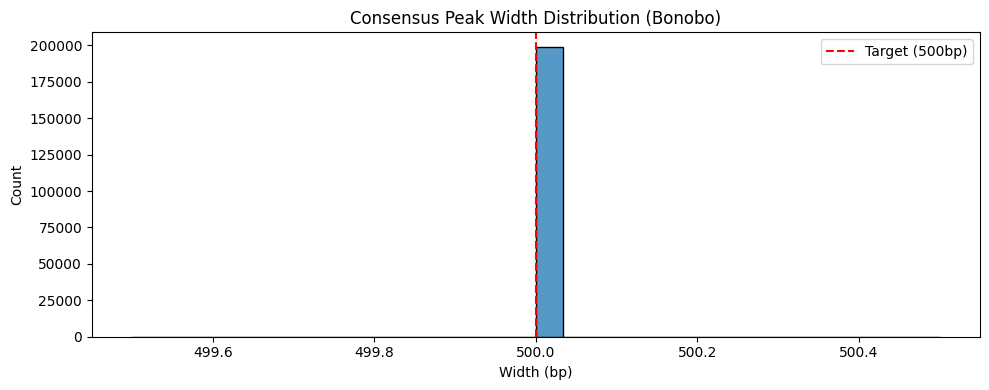

📊 Peak statistics:
   Total peaks: 199,005
   Mean width: 500.0 bp
   Min width: 500 bp
   Max width: 500 bp


In [9]:
# QC 2: Peak width distribution
df = consensus_peaks.df.copy()
df["width"] = df["End"] - df["Start"]

fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(df["width"], bins=30, ax=ax)
ax.set_title(f"Consensus Peak Width Distribution ({SPECIES})")
ax.set_xlabel("Width (bp)")
ax.axvline(x=PEAK_SIZE, color='red', linestyle='--', label=f"Target ({PEAK_SIZE}bp)")
ax.legend()
plt.tight_layout()
plt.show()

print(f"📊 Peak statistics:")
print(f"   Total peaks: {len(df):,}")
print(f"   Mean width: {df['width'].mean():.1f} bp")
print(f"   Min width: {df['width'].min()} bp")
print(f"   Max width: {df['width'].max()} bp")

In [10]:
# QC 3: Per-chromosome distribution
chrom_counts = df.groupby("Chromosome").size().sort_values(ascending=False)
print(f"📊 Peaks per chromosome (top 15):")
print(chrom_counts.head(15))

📊 Peaks per chromosome (top 15):
Chromosome
chr1     20869
chr11    15314
chr3     13370
chr6     13169
chr10    11736
chr5     11302
chr7     10888
chr9     10476
chr8     10029
chr4      9366
chr12     9166
chr2A     8299
chr2B     7981
chr17     7427
chr19     6860
dtype: int64


---

## chr2B Analysis (Bonobo-specific)

Detailed investigation of chr2B peaks to verify the consensus peak generation.

In [11]:
# Filter for chr2B only
chr2b_consensus = consensus_peaks.df[consensus_peaks.df["Chromosome"] == "chr2B"]
print(f"🔬 chr2B consensus peaks: {len(chr2b_consensus)}")
print(f"\nFirst 10 chr2B consensus peaks:")
print(chr2b_consensus[["Chromosome", "Start", "End", "Name", "Score", "Summit"]].head(10))

🔬 chr2B consensus peaks: 7981

First 10 chr2B consensus peaks:
      Chromosome   Start     End                                      Name  \
29168      chr2B  230156  230656                        T_cells_peak_41172   
29169      chr2B  230682  231182                            ECs_peak_13387   
29170      chr2B  231444  231944                   Enterocytes_peak_40166a   
29171      chr2B  232693  233193                 Naive_B_cells_peak_45885b   
29172      chr2B  245997  246497                       T_cells_peak_41177a   
29173      chr2B  246542  247042                   Macrophages_peak_27064a   
29174      chr2B  247216  247716  Specialized_Fibroblasts_SYNM+_peak_6723c   
29175      chr2B  247725  248225                   Colonocytes_peak_33605b   
29176      chr2B  248306  248806                    MUC6+_cells_peak_18430   
29177      chr2B  248860  249360                Plasma_B_cells_peak_33384b   

       Score  Summit  
29168    608     312  
29169  15278     168  
29170    

In [12]:
# Trace chr2B peaks back to source narrowPeak files
# Load one sample's chr2B source peaks and compare

# Get all chr2B peaks from source files
print("🔍 Tracing chr2B consensus peaks back to source...")
sample_name = list(narrow_peaks_dict.keys())[0]
source_peaks = narrow_peaks_dict[sample_name].df
source_chr2b = source_peaks[source_peaks["Chromosome"] == "chr2B"]

print(f"\nSource sample: {sample_name}")
print(f"chr2B source peaks: {len(source_chr2b)}")

if len(source_chr2b) > 0:
    print(f"\nFirst 5 chr2B source peaks:")
    print(source_chr2b[["Chromosome", "Start", "End", "Name", "Score", "Summit"]].head(5))

🔍 Tracing chr2B consensus peaks back to source...

Source sample: Specialized_Fibroblasts_KCNN3+
chr2B source peaks: 197

First 5 chr2B source peaks:
    Chromosome      Start        End  \
911      chr2B  114231886  114232113   
912      chr2B  114373281  114373595   
913      chr2B  114373636  114373991   
914      chr2B  118131292  118131526   
915      chr2B  118358063  118358326   

                                         Name  Score  Summit  
911  Specialized_Fibroblasts_KCNN3+_peak_4094    171     109  
912  Specialized_Fibroblasts_KCNN3+_peak_4095     64     106  
913  Specialized_Fibroblasts_KCNN3+_peak_4096     49     230  
914  Specialized_Fibroblasts_KCNN3+_peak_4097     98     109  
915  Specialized_Fibroblasts_KCNN3+_peak_4098     49     110  


In [13]:
# Verify peak extension calculation for chr2B peaks
# Pick a specific chr2B consensus peak and verify it came from source correctly

if len(chr2b_consensus) > 0 and len(source_chr2b) > 0:
    # Get the first chr2B consensus peak name
    test_peak = chr2b_consensus.iloc[0]
    test_name = test_peak["Name"]
    
    # Find it in source
    source_match = source_peaks[source_peaks["Name"] == test_name]
    
    if len(source_match) > 0:
        src = source_match.iloc[0]
        
        print(f"🔬 Verifying peak: {test_name}")
        print(f"\n📥 SOURCE PEAK:")
        print(f"   Chromosome: {src['Chromosome']}")
        print(f"   Start: {src['Start']}")
        print(f"   End: {src['End']}")
        print(f"   Summit (relative): {src['Summit']}")
        print(f"   Summit (absolute): {src['Start'] + src['Summit']}")
        
        # Calculate expected extension
        half_width = PEAK_SIZE // 2
        expected_start = src['Start'] + src['Summit'] - half_width
        expected_end = src['Start'] + src['Summit'] + half_width
        
        print(f"\n📐 EXPECTED (half_width={half_width}):")
        print(f"   Start: {expected_start}")
        print(f"   End: {expected_end}")
        
        print(f"\n📤 ACTUAL CONSENSUS:")
        print(f"   Start: {test_peak['Start']}")
        print(f"   End: {test_peak['End']}")
        
        print(f"\n📊 DIFFERENCE:")
        start_diff = test_peak['Start'] - expected_start
        end_diff = test_peak['End'] - expected_end
        print(f"   Start diff: {start_diff}")
        print(f"   End diff: {end_diff}")
        
        if start_diff == 0 and end_diff == 0:
            print(f"\n✅ Peak calculation is CORRECT!")
        else:
            print(f"\n❌ Peak calculation has ERRORS!")
    else:
        print(f"Peak {test_name} not found in source sample {sample_name}")

Peak T_cells_peak_41172 not found in source sample Specialized_Fibroblasts_KCNN3+
